In [150]:
import numpy as np
from pathlib import Path
import pickle
from tqdm import tqdm



from pathlib import Path


import matplotlib.pyplot as plt

from ase import Atoms
from pyscf import gto

def pyscf_to_ase(mol):
    """Convert a PySCF Mole object to an ASE Atoms object."""
    symbols = [mol.atom_symbol(i) for i in range(mol.natm)]
    positions = mol.atom_coords(unit="Angstrom")
    return Atoms(symbols, positions=positions)

import os
os.environ["CHARMM_HOME"] = "/pchem-data/meuwly/boittier/home/charmm"
os.environ["CHARMM_LIB_DIR"] = "/pchem-data/meuwly/boittier/home/charmm/build/cmake"
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".5"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())
import sys
import e3x
import jax
import numpy as np
import optax
import orbax
from pathlib import Path
import pandas as pd
# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test")
import physnetjax
sys.path.append("/pchem-data/meuwly/boittier/home/dcm-lj-data")
from pycharmm_lingo_scripts import script1, script2, script2, script3, load_dcm

from physnetjax.data.data import prepare_datasets
from physnetjax.training.loss import dipole_calc
from physnetjax.models.model import EF
from physnetjax.training.training import train_model  # from model import dipole_calc
from physnetjax.data.batches import _prepare_batches as prepare_batches #prepare_batches, prepare_datasets
from physnetjax.calc.helper_mlp import get_ase_calc
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
data_key, train_key = jax.random.split(jax.random.PRNGKey(43), 2)
from physnetjax.restart.restart import get_last, get_files, get_params_model
from physnetjax.analysis.analysis import plot_stats

import pycharmm

import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm

import ase
from ase.io import read as read_ase
from ase import visualize
from ase.visualize import view

ev2kcalmol = 1/(ase.units.kcal / ase.units.mol)


def set_pycharmm_xyz(atom_positions):
    xyz = pd.DataFrame(atom_positions, columns=["x", "y", "z"])
    coor.set_positions(xyz)


def parse_non_int(s):
    return "".join([_ for _ in s if _.isalpha()]).lower().capitalize()


sys.path.append("/pchem-data/meuwly/boittier/home/pyscfgpu/tests/supermolecule")
# from supermol import compute_interaction_energy

sys.path.append("/pchem-data/meuwly/boittier/home/pyscfgpu/helper_functions/")
# from basis import *



[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [151]:
def compute_dft(mol, calcs, xc="b3lyp"):

    engine, mol = setup_mol(mol, xc)

    output = {"mol": mol, "calcs": calcs}

    if CALCS.ENERGY in calcs:
        # Compute Energy
        e_dft = engine.kernel()
        print(f"total energy = {e_dft}")       # -76.46668196729536
        output['energy'] = e_dft

    if CALCS.GRADIENT in calcs:
        # Compute Gradient
        g = engine.nuc_grad_method()
        g_dft = g.kernel()
        output['gradient'] = g_dft

    if CALCS.HESSIAN in calcs:
        # Compute Hessian
        h = engine.Hessian()
        h.auxbasis_response = 2                # 0: no aux contribution, 1: some contributions, 2: all
        engine.cphf_grids.atom_grid = (50,194) # customize grids for solving CPSCF equation, SG1 by default
        h_dft = h.kernel()
        output['hessian'] = h_dft

    if CALCS.HARMONIC in calcs:
        # harmonic analysis
        results = thermo.harmonic_analysis(mol, h_dft)
        thermo.dump_normal_mode(mol, results)
        output['harmonic'] = results

    if CALCS.THERMO in calcs:
        results = thermo.thermo(
            engine,                            # GPU4PySCF object
            results['freq_au'],
            298.15,                            # room temperature
            101325)                            # standard atmosphere

        thermo.dump_thermo(mol, results)
        output['thermo'] = results

    if CALCS.HESSIAN in calcs:
        # force translational symmetry
        natm = mol.natm
        h_dft = h_dft.transpose([0,2,1,3]).reshape(3*natm,3*natm)
        h_diag = h_dft.sum(axis=0)
        h_dft -= np.diag(h_diag)
        output['hessian'] = h_dft

    return output


def create_mol(atom, basis, spin, charge, log_file="./pyscf.log", verbose=True):
    M =  pyscf.M(
        atom=atom,                         # water molecule
        basis=basis,                # basis set
        spin=spin,
        charge=charge,
        output=log_file,              # save log file
        verbose=verbose                          # control the level of print info
        )
    M.build()
    return M

def setup_mol(atom, basis, xc, log_file='./pyscf.log', 
    verbose=6, 
    lebedev_grids=(99,590),
    scf_tol=1e-10,
    scf_max_cycle=50,
    cpscf_tol=1e-3,
    conv_tol=1e-10,
    conv_tol_cpscf=1e-3,
              spin=0,
              charge=1,
    ):
    if type(atom) == str:
        mol = create_mol(atom, basis, spin=spin, charge=charge)
    else:
        mol = atom

    print(mol)
    
    mf_GPU = rks.RKS(                      # restricted Kohn-Sham DFT
        mol,                               # pyscf.gto.object
        xc=xc                         # xc funtionals, such as pbe0, wb97m-v, tpss,
        ).density_fit()                    # density fitting

    mf_GPU.grids.atom_grid = lebedev_grids      # (99,590) lebedev grids, (75,302) is often enough
    mf_GPU.conv_tol = scf_tol                   # controls SCF convergence tolerance
    mf_GPU.max_cycle = scf_max_cycle            # controls max iterations of SCF
    mf_GPU.conv_tol_cpscf = conv_tol_cpscf      # controls max iterations of CPSCF (for hessian)

    return mf_GPU, mol
import pyscf

import sys
import numpy as np
import pyscf
from pyscf.hessian import thermo
from gpu4pyscf.dft import rks

sys.path.append("/pchem-data/meuwly/boittier/home/pyscfgpu/tests/supermolecule")
from supermol import compute_interaction_energy

sys.path.append("/pchem-data/meuwly/boittier/home/pyscfgpu/helper_functions/")
from basis import *

# Flat arrays for Nα and Nβ values
elements = [
    'Hydrogen', 'Helium', 'Lithium', 'Beryllium', 'Boron', 'Carbon', 'Nitrogen', 
    'Oxygen', 'Fluorine', 'Neon', 'Sodium', 'Magnesium', 'Aluminum', 'Silicon', 
    'Phosphorus', 'Sulfur', 'Chlorine'
]

Nalpha = [1, 0, 1, 0, 1, 1, 2, 2, 2, 0, 1, 0, 1, 1, 2, 2, 2]
Nbeta  = [0, 0, 0, 0, 0, 1, 1, 2, 3, 0, 0, 0, 0, 1, 1, 2, 3]
spins = np.array(Nalpha) - np.array(Nbeta)
zs = range(1,18)
Eref = np.zeros([20], dtype=float)
for z, s in zip(zs, spins):
    engine, mol = setup_mol(f"{z} -1000. -1000. -1000.; {z} 1000. 1000. 1000. ", "aug-cc-pVDZ", "b3lyp", spin = 2*s, charge=0)
    e_dft = engine.kernel()/2
    Eref[z] = e_dft


overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log
overwrite output file: ./pyscf.log


In [152]:



# Eref[1] = -0.498232909223
# Eref[6] = -37.731440432799
# Eref[8] = -74.878159582108
# Eref[17] = -459.549260062932


In [153]:
Eref

array([ 0.00000000e+00, -2.09881557e-01, -2.90909618e+00, -7.38363661e+00,
       -1.46712726e+01, -2.24660543e+01, -3.77882109e+01, -5.06508815e+01,
       -7.49758710e+01, -9.15200257e+01, -1.28928031e+02, -1.62184220e+02,
       -2.00091275e+02, -2.42241694e+02, -2.89348214e+02, -3.39503102e+02,
       -3.97230722e+02, -4.55076887e+02,  0.00000000e+00,  0.00000000e+00])

In [175]:
restart = None
TRAIN_ML = True
RESTART_ML = True
ANALYSE_ML = True
DATA = False
batch_size = 4
DATA_KEYS = ("Z", "R", "E", "F", "N")

# DATA = [
#     Path("/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz"),

# ]

model = EF(
    # attributes
    features=128,
    max_degree=1,
    num_iterations=2,
    num_basis_functions=64,
    cutoff=8.0,
    max_atomic_number=19,
    charges=False,
    natoms=10,
    total_charge=0,
    n_res=2,
    zbl=True,
    debug=False,
)



In [155]:
import pint

# Create a UnitRegistry instance
ureg = pint.UnitRegistry()

# Define Hartree value (for example)
hartree_value = 1 * ureg.hartree

# Convert from Hartree to eV
ev_value = hartree_value.to(ureg.eV)
Q_ = ureg.Quantity
# Convert from eV to kcal/mol
# kcal_per_mol_value = ev_value.to(ureg.kcal / ureg.mol)
an = Q_('N_A')
q = Q_(10.**10)
print((q / an).to('mole'))



1.6605390671738466e-14 mole


In [156]:
ureg.define('NA = 6.02214076*10**23 = n_atoms')

In [157]:
1 * ureg("NA").to("count")

<Quantity(6.02214076e+23, 'count')>

In [158]:
eV = 1 * ureg("eV")
kcal = 1 * ureg("kcal")
# mol_unit = 1 * ureg("mol")

(kcal).to("eV")

<Quantity(2.6114474e+22, 'electron_volt')>

In [ ]:
def job_units(key):
    _ = 1 * ureg("")
    match key:
        case "F":
            _ = 1 * ureg("E_h/bohr").to("eV/angstrom")
        case "R":
            _ = 1 * ureg("angstrom").to("angstrom")
        case "E":
            _ = ureg("E_h").to("eV")
    
    return _

def job_units(key):
    _ = 1 * ureg("")
    match key:
        case "F":
            _ = 1 * ureg("E_h/bohr").to("eV/angstrom") * 27.
        case "R":
            _ = 1 * ureg("angstrom").to("angstrom") 
        case "E":
            _ = ureg("E_h").to("eV") * 27.0
    
    return _

In [ ]:
    
from ase.units import Hartree, Bohr, kcal, Angstrom

def job_res_to_dataset(res, k=None, Eref = None):
    mol = pyscf_to_ase(res["mol"])
    R = mol.get_positions()
    Z = mol.get_atomic_numbers()
    F = res["gradient"]
    E = res["energy"] 
    if Eref is not None:
        E = E - (Eref[Z].sum()) 
    result = { "Z": Z, "R": R, "F":  -1*F, "E": E, "N": len(Z) }
    if k is not None:
        result["key"] = k
    for k,v in result.items():
        result[k] = result[k] * job_units(k).magnitude
    return result

def get_units(results):
    units = {}
    for k,v in results.items():
        results[k] = results[k] * job_units(k).magnitude
        units[k] = job_units(k).units
    return units


In [ ]:
fns = Path("/pchem-data/meuwly/boittier/home/project-mmml/eric-copy/").glob("*pickle")
fns = list(fns)[:]
len(fns)

data_arrays = [pd.read_pickle(fn) for fn in fns]

data = {}
for i in range(len(fns)):
    key_append = str(fns[i].stem) + "/"
    _ = data_arrays[i]
    _ = {(key_append + k[0], k[1], k[2]): v for k,v in _.items()}
    data.update(_)



data_for_model = [job_res_to_dataset(v["results"]["results_AB"], k, Eref) for k,v in data.items()]

In [ ]:
Es = [_["E"] for _ in data_for_model ]

Es

In [ ]:
get_units(data_for_model[0])

In [ ]:
data_for_model = data_for_model[1:]

In [ ]:
m = data_arrays[0][list(data_arrays[0].keys())[0]]["results"]["results_AB"]["mol"]
ase_atoms = pyscf_to_ase(m)

ase.visualize.view(ase_atoms, viewer="x3d")

In [166]:
print(ase)

<module 'ase' from '/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/ase/__init__.py'>


In [167]:
len(data_for_model)

17535

In [168]:
from physnetjax.data.datasets import process_in_memory

train_data = process_in_memory(data_for_model[0::3], max_atoms=10)
valid_data = process_in_memory(data_for_model[1::3], max_atoms=10)


In [169]:


# if DATA:
#     train_data, valid_data = prepare_datasets(
#         data_key,
#         16801,
#          4200,
#         files,
#         clip_esp=False,
#         natoms=NATOMS,
#         clean=False,
#         subtract_atom_energies=False,
#         verbose=True,
#     )
    
#     ntest = len(valid_data["E"]) // 3
#     test_data = {k: v[ntest:] for k, v in valid_data.items()}
#     valid_data = {k: v[:ntest] for k, v in valid_data.items()}
    
#     DEFAULT_DATA_KEYS = ["Z", "R", "D", "E", "F", "N"]
#     batch_size = 11
    
#     test_batches = prepare_batches(data_key, test_data, batch_size,
#                                   num_atoms=NATOMS,
#                                   data_keys=DEFAULT_DATA_KEYS)
    
#     train_batches = prepare_batches(data_key, train_data, batch_size,
#                                   num_atoms=NATOMS,
#                                   data_keys=DEFAULT_DATA_KEYS)
    
#     valid_batches = prepare_batches(data_key, valid_data, batch_size,
#                                   num_atoms=NATOMS,
#                                   data_keys=DEFAULT_DATA_KEYS)




In [176]:
import lovely_jax, lovely_numpy
from lovely_numpy import plot


In [177]:
pd.DataFrame({"train": train_data["E"], "valid": valid_data["E"]}).describe()


,train,valid
count,5845.000000,5845.000000
mean,-619.569882,-619.571331
std,0.114598,0.113233
min,-619.782327,-619.775288
25%,-619.642618,-619.642509
50%,-619.571954,-619.573789
75%,-619.500687,-619.502519
max,-618.990715,-619.060646


In [178]:
print(train_data["E"] - train_data["E"].min())

[0.02479475 0.02783165 0.03170722 ... 0.09259133 0.11641323 0.13474269]


In [179]:
if TRAIN_ML:
    params = train_model(
        train_key,
        model,
        train_data,
        valid_data,
        num_epochs=int(2e6),
        learning_rate=0.001,
        # energy_weight=1,
        # dipole_weight=1,
        # charges_weight=1,
        # forces_weight=1,
        schedule_fn="cosine",
        optimizer="amsgrad",
        batch_size=1,
        num_atoms=10,
        data_keys=DATA_KEYS,
        name="dcme-pyscf",
        print_freq=1,
        objective="valid_loss",
        best=2e6,
        batch_method="default",
    )


                                           PhysNetJax Training Progress                                            
┏━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃       ┃         ┃           ┃           ┃           ┃           ┃ Train     ┃ Valid     ┃ Train     ┃ Valid     ┃
┃       ┃         ┃           ┃ Train     ┃ Valid     ┃           ┃ Energy    ┃ Energy    ┃ Forces    ┃ Forces    ┃
┃ Epoch ┃ time    ┃ Eff. LR   ┃ Loss      ┃ Loss      ┃ Best Loss ┃ MAE       ┃ MAE       ┃ MAE       ┃ MAE       ┃
┡━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│   1   │ 60.29 s │ Array     │  497907.… │  6376.342 │ 6376.342  │  3295.739 │  552.502  │  239.034  │   42.826  │
│       │         │ gpu:0     │           │           │           │           │           │           │           │
│       │         │ 0.001     │           │           │           │           │           │           │           │
└───────┴─────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━┓
┃ Checkpoint                                                                                                   ┃  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━┩
│ /pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dcme-pyscf-7a182f0e-e1ed-4d3c-a199-9eaadfc80c15/epoch-1 │  │
└──────────────────────────────────────────────────────────────────────────────────────────────────────────────┴──┘

...

KeyboardInterrupt: 

In [ ]:

plot_stats?

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 8.0    │ False │ False │ 48     │ 19     │ 0      │ 2     │ 10     │ 30     │ 2       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                 ┃ name      ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharmm… │ epoch-217 │ 217   │ Array gpu:0 0.994 │ 2025-02-28 13:47:01.202083 │
└────────────────────────────────────────────┴───────────┴───────┴───────────────────┴────────────────────────────┘

243it [02:32,  1.59it/s]


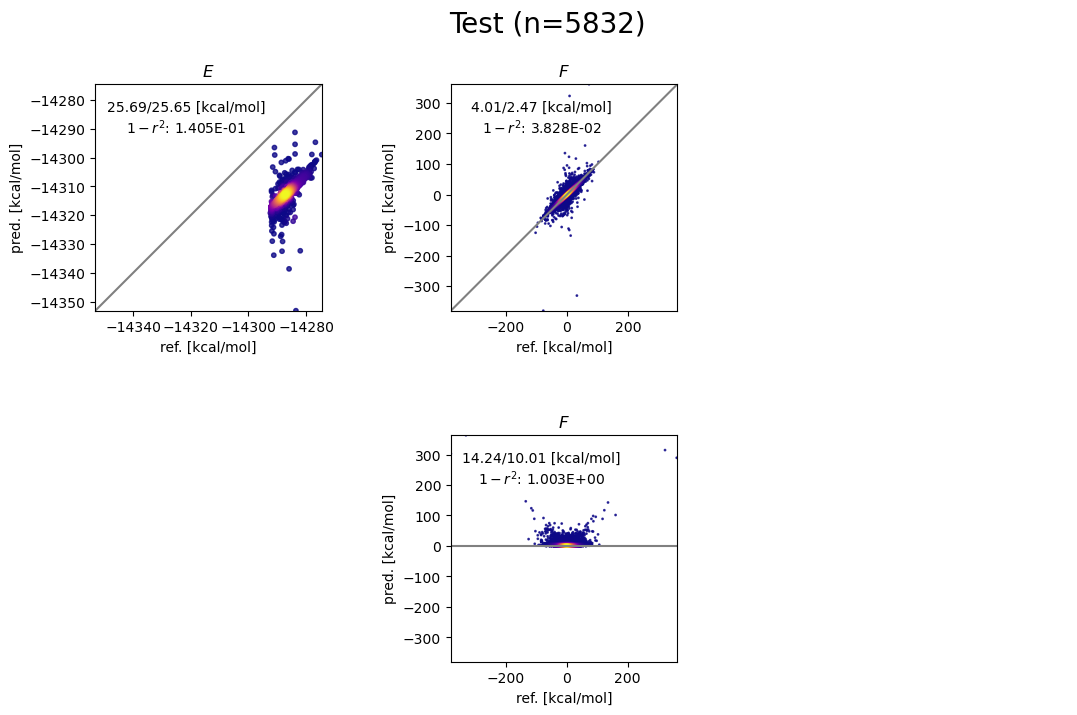

In [174]:

from physnetjax.restart.restart import get_last, get_files, get_params_model
from physnetjax.analysis.analysis import plot_stats


restart_path = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dcme-pyscf-613e551d-8a1b-4175-9cd4-afd809f4c201/"
restart = get_last(restart_path)
params, model = get_params_model(restart)
model.natoms = NATOMS = 10

if ANALYSE_ML:
    batch_size = 24
    test_data = process_in_memory(data_for_model[2::3], max_atoms=10)
    test_batches = prepare_batches(data_key, test_data, batch_size,
                                  num_atoms=NATOMS,
                                  data_keys=DATA_KEYS)
    
    output = plot_stats(test_batches, model, params, _set="Test",
                   do_kde=True, batch_size=batch_size)




In [139]:
pd.DataFrame(test_data["E"]*23).describe()

,0
count,5845.000000
mean,-14250.142057
std,2.605854
min,-14254.875754
25%,-14251.761319
50%,-14250.199748
75%,-14248.581745
max,-14237.074587


In [113]:
o = output
shifts = (o["Es"] - o["predEs"])
shift = shifts.mean()
shift

np.float64(5.773458624899793)

In [118]:
(np.mean((o["Es"] - (o["predEs"] - shift))**2))**0.5

np.float64(16.370693439528456)

In [119]:
ms1 = (o["predEs"] + shift) - ( o["predEs"] + shift).mean()

In [120]:
ms2 = (o["Es"] - o["Es"].mean())

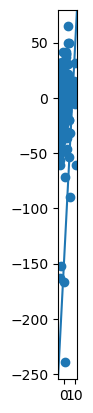

In [122]:
plt.scatter(ms2, ms1)
plt.plot([0,1], [0, 1], transform=plt.gca().transAxes)
plt.gca().set_aspect("equal")

In [123]:
if TRAIN_ML:
    params = train_model(
        train_key,
        model,
        train_data,
        valid_data,
        num_epochs=int(2e6),
        learning_rate=0.001,
        energy_weight=10,
        # dipole_weight=1,
        # charges_weight=1,
        # forces_weight=1,
        schedule_fn="constant",
        optimizer="amsgrad",
        batch_size=1,
        num_atoms=NATOMS,
        data_keys=DATA_KEYS,
        restart=restart_path,
        name="dcme-pyscf",
        print_freq=1,
        objective="valid_loss",
        best=2e6,
        batch_method="default",
    )

                                           PhysNetJax Training Progress                                            
┏━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃       ┃         ┃           ┃           ┃           ┃           ┃ Train     ┃ Valid     ┃ Train     ┃ Valid     ┃
┃       ┃         ┃           ┃ Train     ┃ Valid     ┃           ┃ Energy    ┃ Energy    ┃ Forces    ┃ Forces    ┃
┃ Epoch ┃ time    ┃ Eff. LR   ┃ Loss      ┃ Loss      ┃ Best Loss ┃ MAE       ┃ MAE       ┃ MAE       ┃ MAE       ┃
┡━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│  80   │ 21.99 s │ Array     │  792.325  │   98.420  │   39.902  │  103.726  │   21.457  │   38.142  │    6.647  │
│       │         │ gpu:0     │           │           │           │           │           │           │           │
│       │         │ 0.001     │           │           │           │           │           │           │           │
│  81   │ 10.01 s │ Array     │  557.054  │   97.335  │   39.902  │  112.852  │   10.866  │   31.248  │    6.387  │
│       │         │ gpu:0     │           │           │           │           │           │           │           │
│       │         │ 0.001     │           │           │           │           │           │           │           │
│  82   │ 9.97 s  │ Array     │  399.897  │   90.169  │   39.902  │  103.964  │   21.512  │   25.775  │    5.795  │
│       │         │ gpu:0     │           │           │           │           │           │           │           │
│       │         │ 0.001     │           │           │           │           │           │           │           │
│  83   │ 10.00 s │ Array     │  371.847  │   72.770  │   39.902  │  114.770  │   10.802  │   21.718  │    5.558  │
│       │         │ gpu:0     │           │           │           │           │           │           │           │
│       │         │ 0.001     │           │           │           │           │           │           │           │
│  84   │ 10.03 s │ Array     │  323.435  │   73.564  │   39.902  │  103.837  │   12.232  │   19.790  │    5.022  │
│       │         │ gpu:0     │           │           │           │           │           │           │           │
│       │         │ 0.001     │           │           │           │           │           │           │           │
│  85   │ 10.52 s │ Array     │  283.834  │   73.698  │   39.902  │  101.235  │   10.863  │   17.850  │    4.833  │
│       │         │ gpu:0     │           │           │           │           │           │           │           │
│       │         │ 0.001     │           │           │           │           │           │           │           │
│  86   │ 10.27 s │ Array     │  262.554  │   65.286  │   39.902  │   94.888  │    8.643  │   17.879  │    4.574  │
│       │         │ gpu:0     │           │           │           │           │           │           │           │
│       │         │ 0.001     │           │           │           │           │           │           │           │
│  87   │ 10.08 s │ Array     │  204.592  │   63.625  │   39.902  │   90.559  │   13.006  │   13.768  │    4.246  │
│       │         │ gpu:0     │           │           │           │           │           │           │           │
│       │         │ 0.001     │           │           │           │           │           │           │           │
│  88   │ 10.17 s │ Array     │  323.907  │   59.899  │   39.902  │  125.394  │   13.713  │   14.412  │    4.306  │
│       │         │ gpu:0     │           │           │           │           │           │           │           │
│       │         │ 0.001     │           │           │           │           │           │           │           │
└───────┴─────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
     Last Checkpoint                                    

...


KeyboardInterrupt



In [ ]:
#### Idea: flip the sign of the forces on different fractions of the data set and observe bias in prediction error, training dynamics


In [ ]:
m = data_arrays[0][list(data_arrays[0].keys())[0]]["results"]["results_AB"]["mol"]
ase_atoms = pyscf_to_ase(m)

ase.visualize.view(ase_atoms, viewer="x3d")

# TODO: add default keys to the conversion dict
ase_calc_monomer = get_ase_calc(params, model, 
                                ase_atoms, conversion={"energy": 1/ev2kcalmol, "dipole": 1, "forces": 1/ev2kcalmol})
ase_atoms.calc = ase_calc_monomer
float(ase_atoms.get_potential_energy())

In [ ]:
res_e = data_arrays[0][list(data_arrays[0].keys())[0]]["results"]["results_AB"]["energy"] / Hartree
ae = (Eref[ase_atoms.get_atomic_numbers()].sum() / Hartree) * ev2kcalmol

In [ ]:
ae, res_e, res_e - ae

In [ ]:
o = output
shifts = (o["Es"] - o["predEs"])
shift = shifts.mean()
shift

In [168]:

atoms.set_calculator(MessagePassingCalculator())

# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [169]:
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(atoms).run(fmax=0.001,steps=100)
print()

      Step     Time          Energy          fmax
BFGS:    0 18:08:52      -88.188461        0.272456
BFGS:    1 18:08:52      -88.192413        0.221569
BFGS:    2 18:08:52      -88.197495        0.232659
BFGS:    3 18:08:52      -88.200851        0.161275
BFGS:    4 18:08:52      -88.202843        0.104407
BFGS:    5 18:08:52      -88.205154        0.156042
BFGS:    6 18:08:52      -88.207809        0.157240
BFGS:    7 18:08:52      -88.211075        0.159381
BFGS:    8 18:08:52      -88.213455        0.113953
BFGS:    9 18:08:52      -88.215355        0.110037
BFGS:   10 18:08:52      -88.217293        0.107526
BFGS:   11 18:08:52      -88.219162        0.144758
BFGS:   12 18:08:52      -88.221558        0.121520
BFGS:   13 18:08:52      -88.223000        0.145118
BFGS:   14 18:08:53      -88.225227        0.126019
BFGS:   15 18:08:53      -88.227386        0.144984
BFGS:   16 18:08:53      -88.228462        0.126035
BFGS:   17 18:08:53      -88.230453        0.178590
BFGS:   18 18:

In [170]:
print(atoms.get_dipole_moment())
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')
# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()

[[ 0.23784563 -0.5247692  -0.61293554]]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [171]:
# Parameters.
temperature = 300
timestep_fs = 0.5
num_steps = 10_00

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
dipoles = np.zeros((num_steps, 1, 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  dipoles[i]=atoms.get_dipole_moment()
  # Occasionally print progress.q
  if i % 1000 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

step     0 epot -88.535 ekin  1.106 etot -87.429


In [172]:
view.getModel().setCoordinates(frames[::10], 'array')
view.animate({'loop': None, 'interval': 0.1})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.